In [1]:
# input: iturbide_gaia-data
# output: manual-periodogram

import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

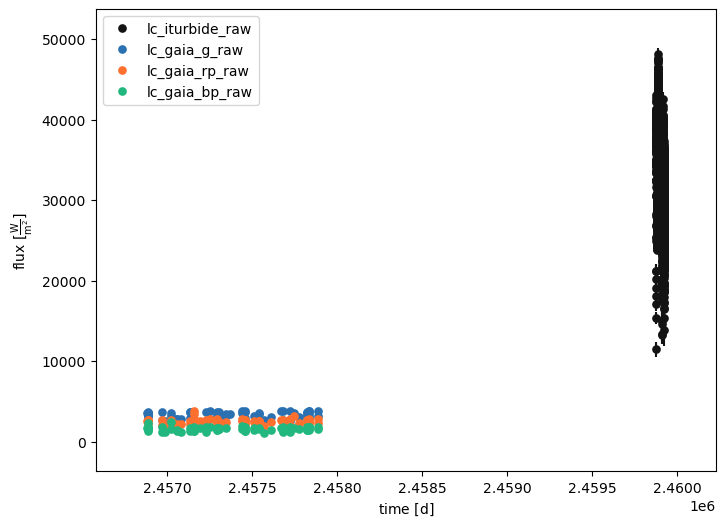

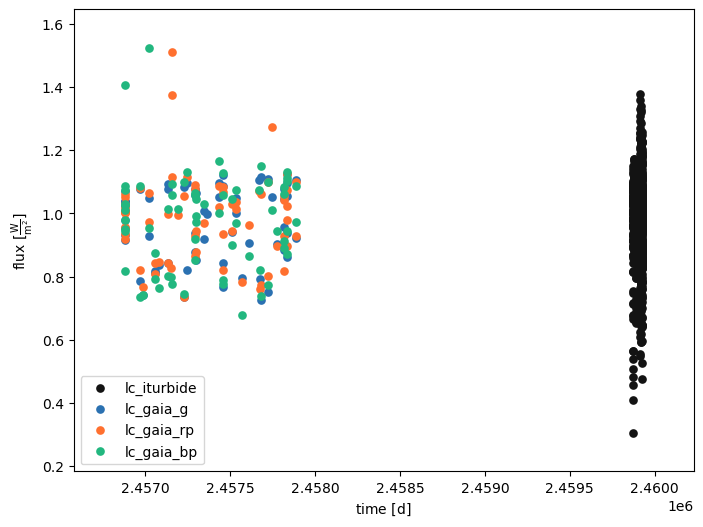

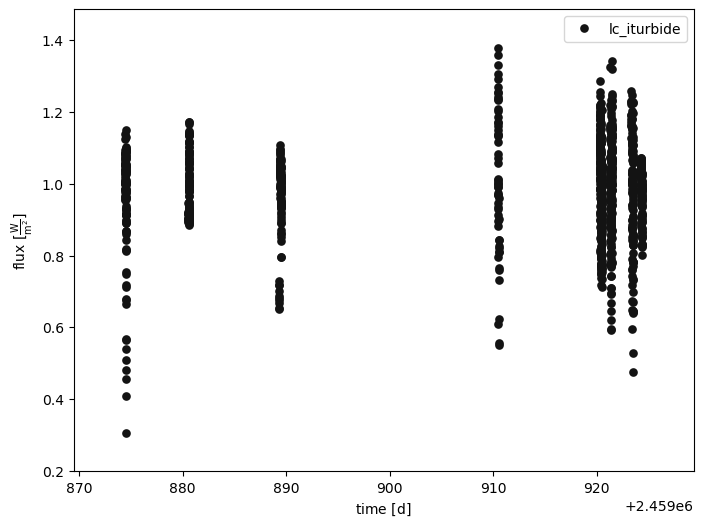

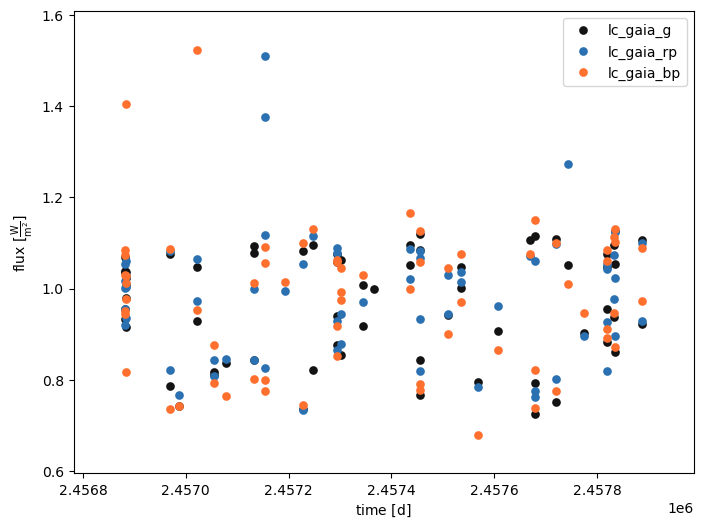

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [2]:
b = phoebe.load("../bundle-saves/iturbide_gaia-data")
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' in d], show=True, legend=True, marker='.')
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.')

b.plot(dataset='lc_iturbide', show=True, legend=True, marker='.')
b.plot(dataset=[d for d in b.datasets if 'gaia' in d and 'raw' not in d], show=True, legend=True, marker='.')

In [3]:
manualPeriodSample = phoebe.linspace(0.04, 0.5, 1000)*u.d

## Iturbide only

In [4]:
[b.disable_dataset(d) for d in b.datasets if d != 'mesh01']
b.enable_dataset('lc_iturbide')
print(b['enabled'])

ParameterSet: 18 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@mesh01@fast_compute...: True
   enabled@lc_iturbide@phoebe0...: True
   enabled@lc_iturbide@fast_co...: True
   enabled@lc_iturbide_raw@pho...: False
   enabled@lc_iturbide_raw@fas...: False
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_g@fast_comp...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_rp@fast_com...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_bp@fast_com...: False
   enabled@lc_gaia_g_raw@phoeb...: False
   enabled@lc_gaia_g_raw@fast_...: False
   enabled@lc_gaia_rp_raw@phoe...: False
   enabled@lc_gaia_rp_raw@fast...: False
   enabled@lc_gaia_bp_raw@phoe...: False
   enabled@lc_gaia_bp_raw@fast...: False


In [5]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_iturbide_manual', overwrite=True,
             algorithm='ls', sample_mode='manual',
             sample_periods=manualPeriodSample)
print(b.filter(solver='lcperiod_iturbide_manual'))

ParameterSet: 8 parameters
   comments@lcperiod_iturbide_...: 
   use_server@lcperiod_iturbid...: none
   algorithm@lcperiod_iturbide...: ls
   lc_datasets@lcperiod_iturbi...: ['*']
   lc_combine@lcperiod_iturbid...: median
   component@lcperiod_iturbide...: binary
   sample_mode@lcperiod_iturbi...: manual
   sample_periods@lcperiod_itu...: [0.04       0.04046046
 0.04092092 ... 0.49907908
 0.49953954 0.5       ] d


ParameterSet: 10 parameters
R  period@lcperiod_iturbide_ma...: [0.5        0.49953954
 0.49907908 ...
 0.04092092 0.04046046
 0.04      ] d
R  power@lcperiod_iturbide_man...: [0.01334728 0.01204566
 0.01467718 ...
 0.00805026 0.00148422
 0.00185511]
   period_factor@lcperiod_itur...: 1.0
R  fitted_twigs@lcperiod_iturb...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_itur...: [0.16662662662662664]
R  fitted_units@lcperiod_iturb...: ['d']
   adopt_parameters@lcperiod_i...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_iturb...: True
   comments@lcperiod_iturbide_...: 


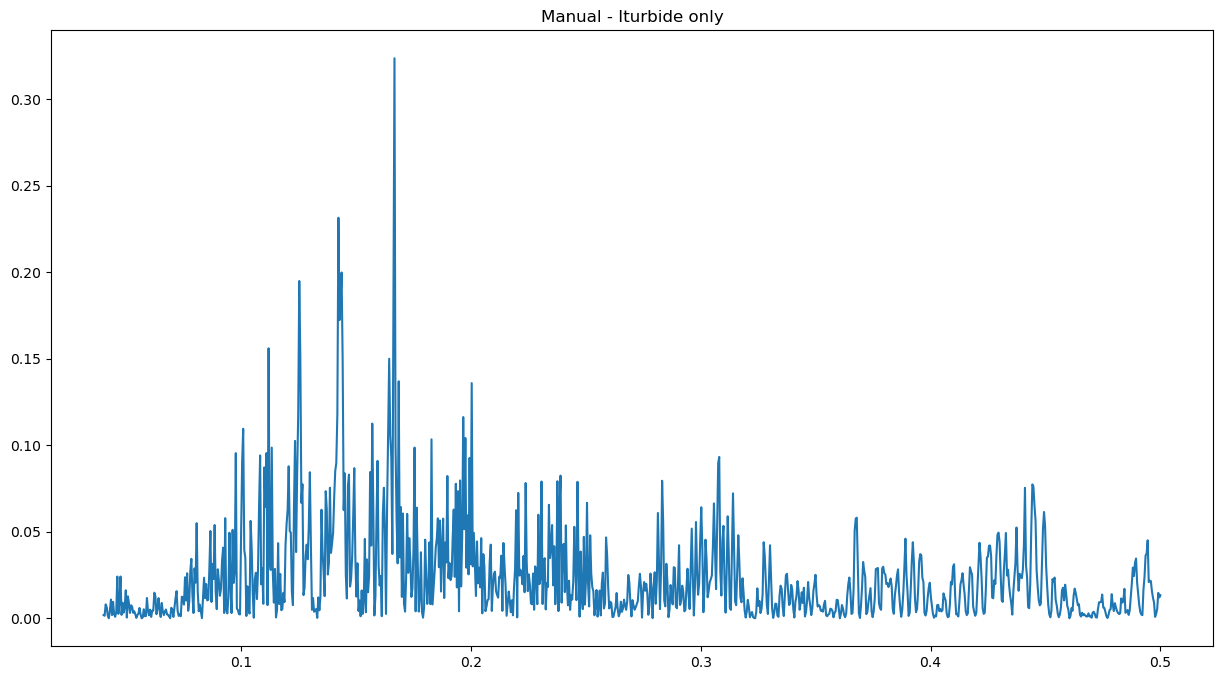

In [6]:
b.run_solver('lcperiod_iturbide_manual', solution='lcperiod_iturbide_manual_solution', overwrite=True)

print(b['lcperiod_iturbide_manual_solution'])
plt.plot(b.get_value('period@lcperiod_iturbide_manual_solution'), b.get_value('power@lcperiod_iturbide_manual_solution'))
plt.title("Manual - Iturbide only")
plt.show()

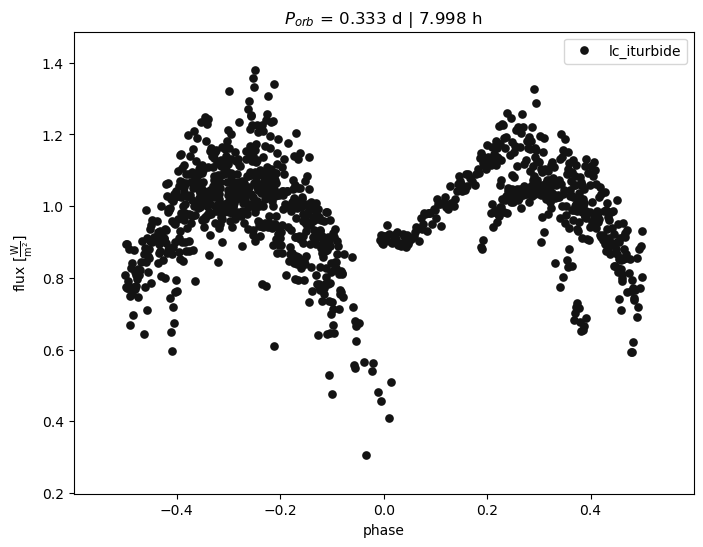

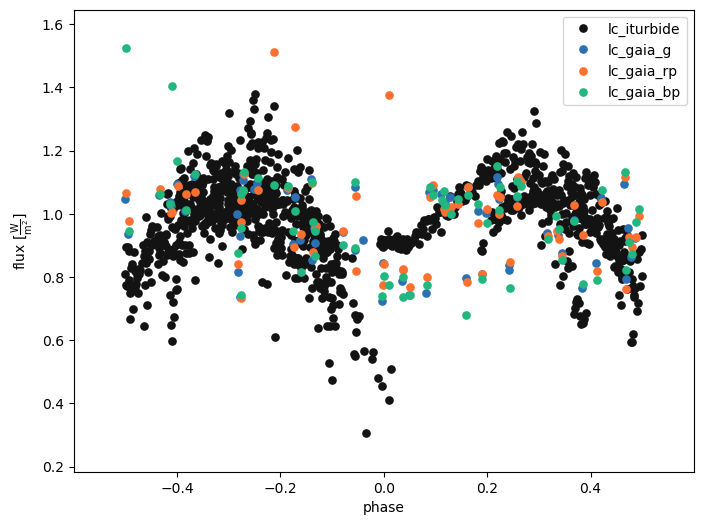

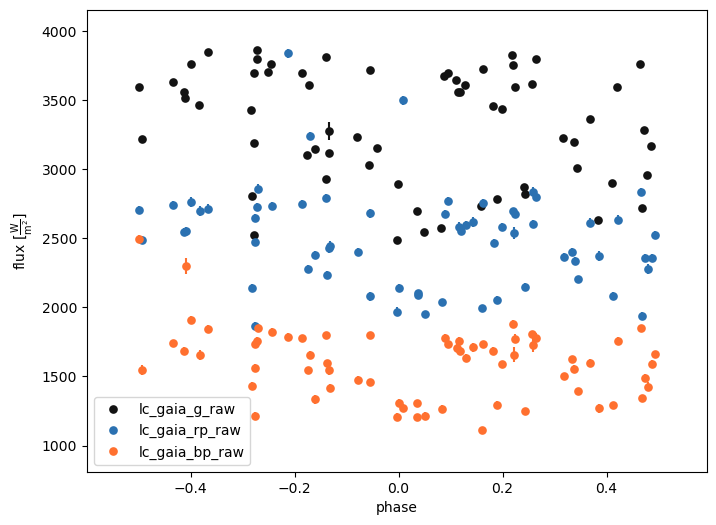

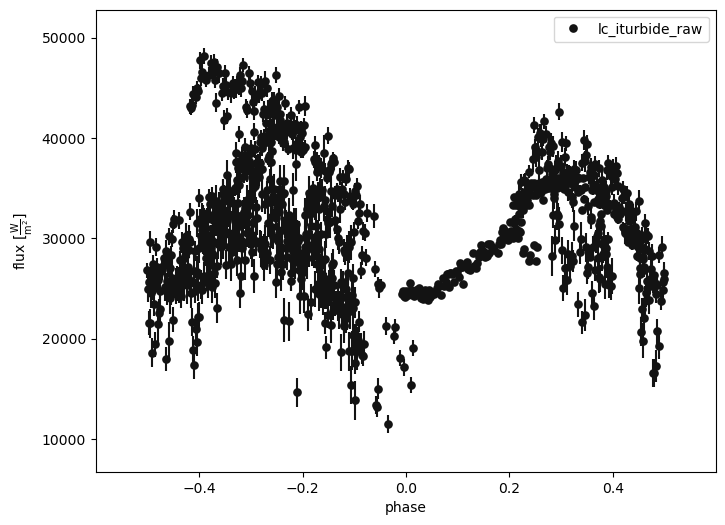

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [7]:
b.adopt_solution('lcperiod_iturbide_manual_solution', period_factor=2)
period = b.get_quantity(qualifier='period', component='binary')
gen_utils.phasePlotEnabledData(b)
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' in d and 'gaia' in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

In [8]:
b.save("./bundle-saves/manual-periodogram")

'./bundle-saves/manual-periodogram'

## Individual Gaia datasets only

**Conclusion**: period estimate seems correct with a manual sample and a `period_factor` = 2, but data itself doesn't seem too organized when phase plotted.

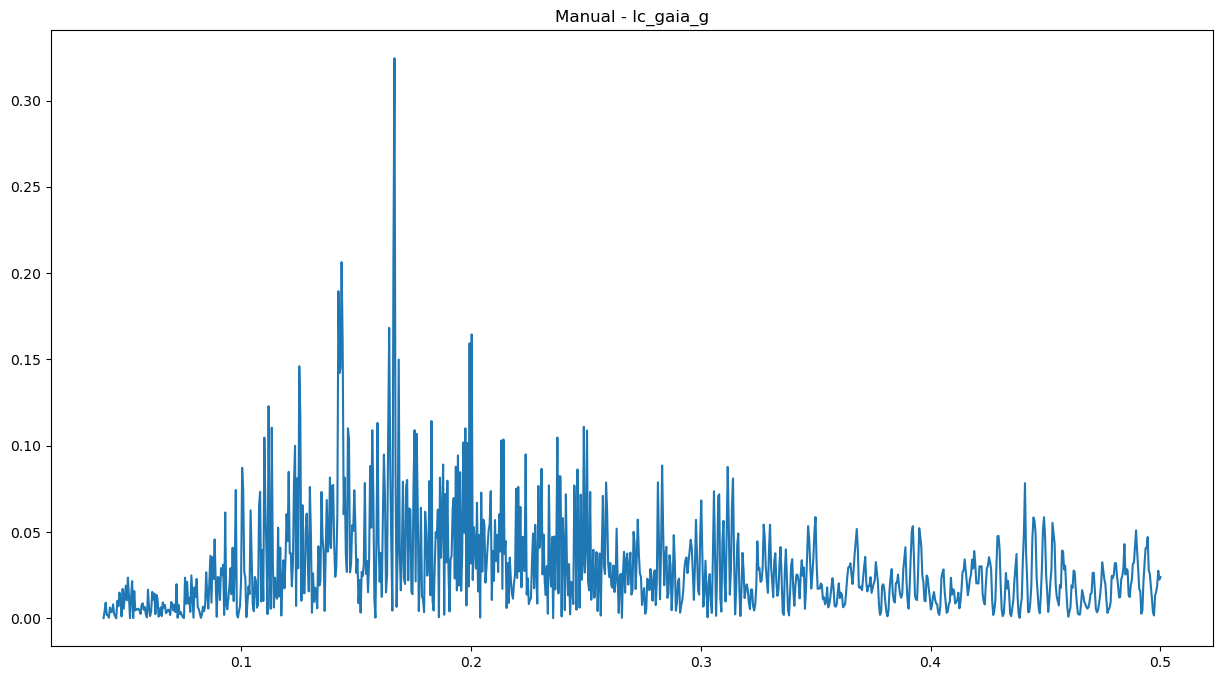

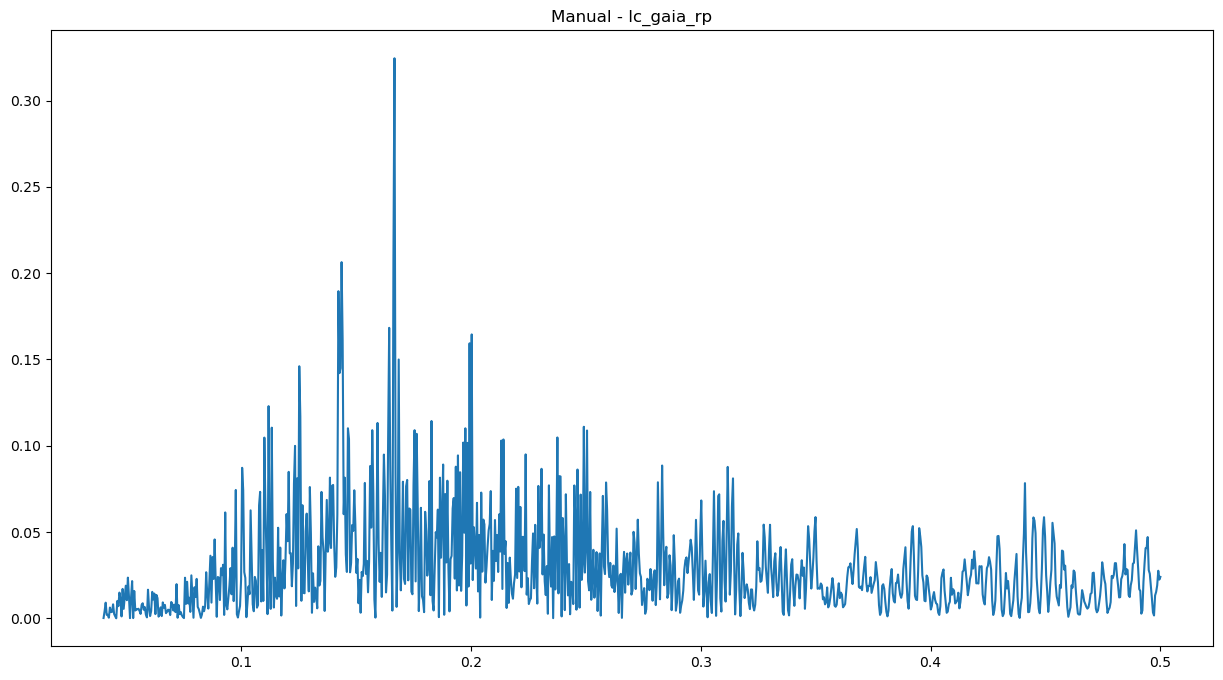

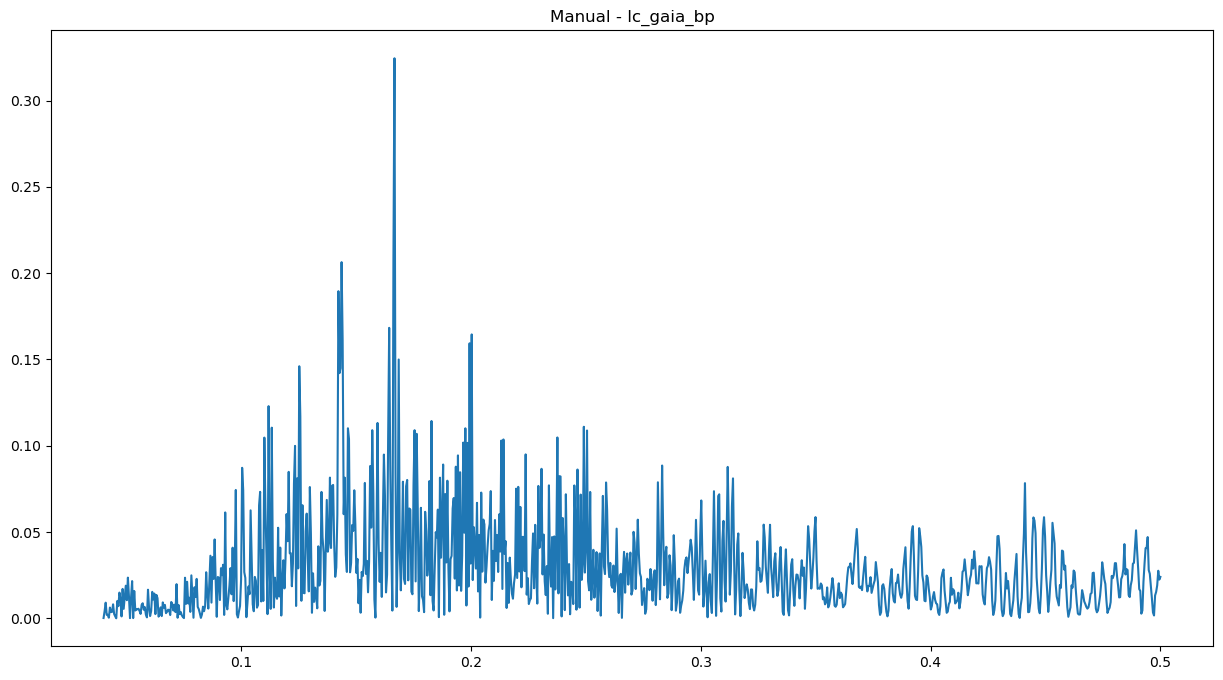

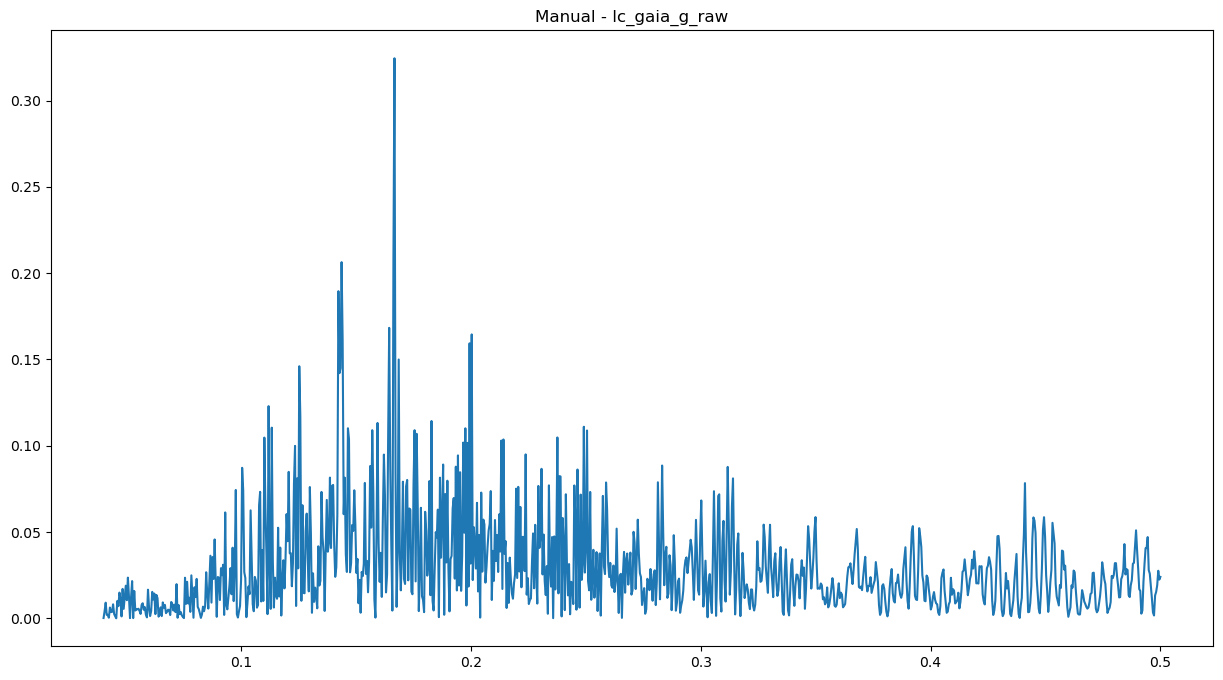

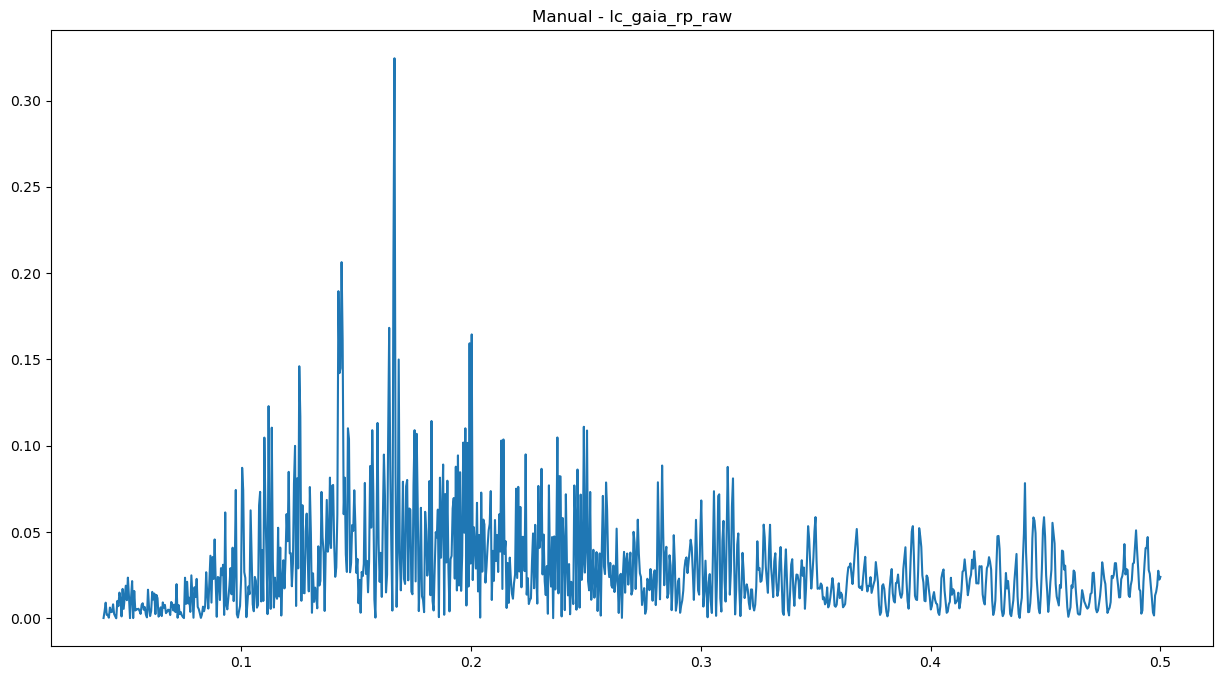

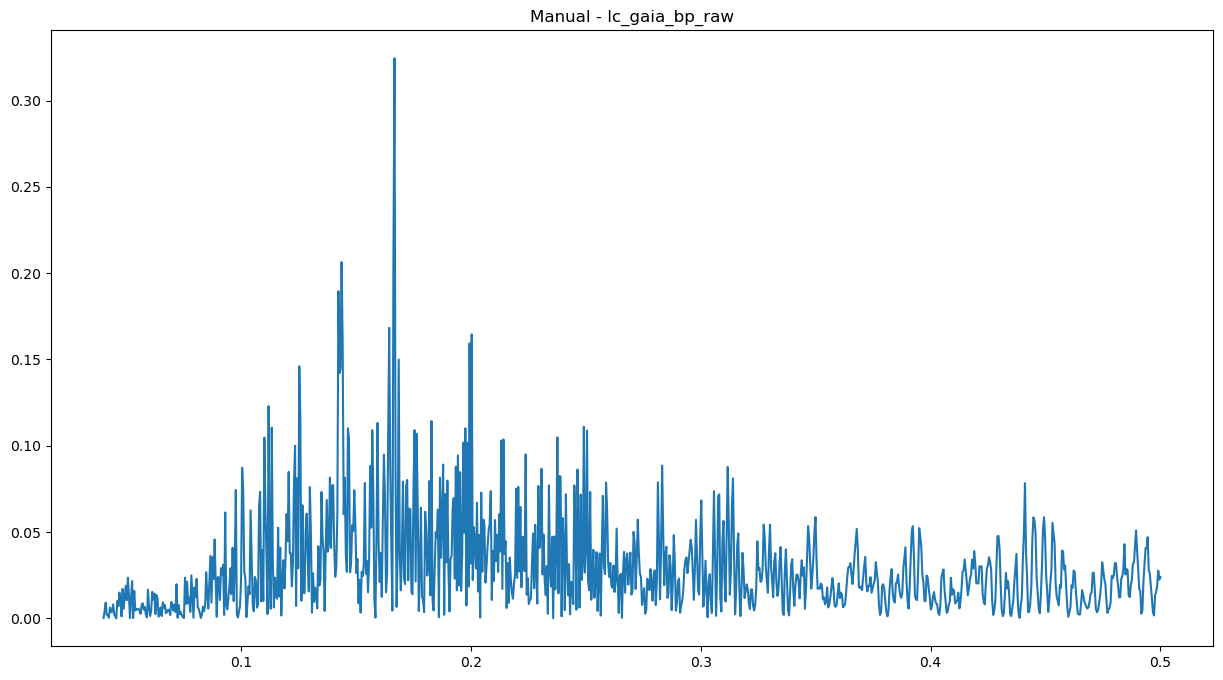

In [10]:
for gaiaDataset in [d for d in b.datasets if 'gaia' in d]:
    [b.disable_dataset(d) for d in b.datasets]
    b.enable_dataset(gaiaDataset)
    
    solverLabel = f"lcperiod_{gaiaDataset}_manual"
    solutionLabel = f"{solverLabel}_solution"
    b.add_solver('estimator.lc_periodogram', solver=solverLabel, overwrite=True,
                 algorithm='ls', sample_mode='manual', sample_periods=manualPeriodSample)
    b.run_solver(solverLabel, solution=solutionLabel, overwrite=True)
    
    b.adopt_solution(solutionLabel, period_factor=2)
    # gen_utils.plotEnabledData(b, title=gaiaDataset, draw_title=True)
    # gen_utils.phasePlotEnabledData(b)

    plt.plot(b.get_value(f'period@{solutionLabel}'), b.get_value(f'power@{solutionLabel}'))
    plt.title(f"Manual - {gaiaDataset}")
    plt.show()
    

7.998078078078079 h


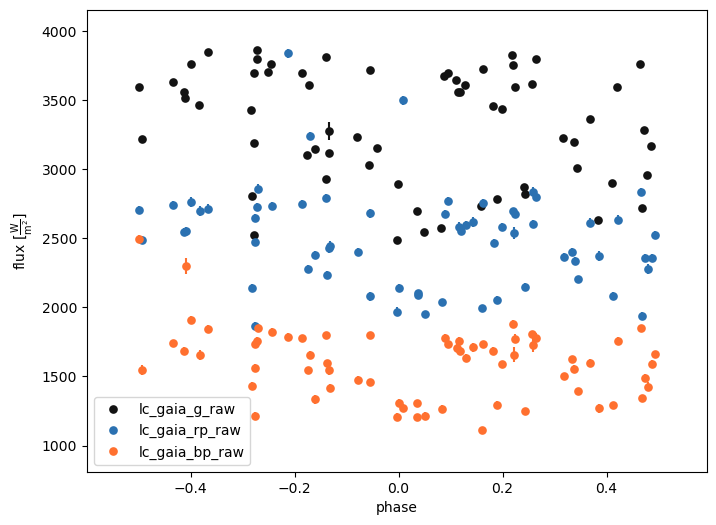

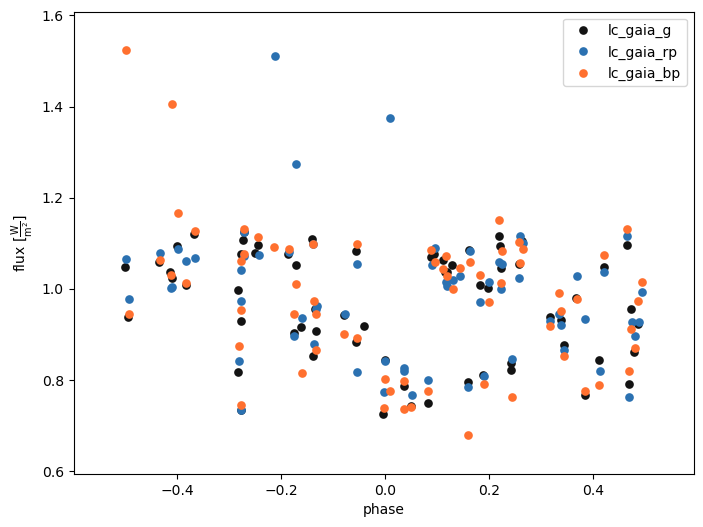

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [11]:
print(b.get_quantity(qualifier='period', component='binary', unit=u.hour))
b.plot(x='phase', dataset=[d for d in b.datasets if 'gaia' in d and 'raw' in d], show=True, legend=True, marker='.')
b.plot(x='phase', dataset=[d for d in b.datasets if 'gaia' in d and 'raw' not in d], show=True, legend=True, marker='.')